<img src="../images/QISKit-c.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="250 px" align="left">

## _*VQE algorithm: application to optimization problems*_ 

The latest version of this notebook is available on https://github.com/IBM/qiskit-sdk-py/tree/master/scripts.

For more information about how to use the IBM Q experience (QX), consult the [IBM Q experience tutorials](https://quantumexperience.ng.bluemix.net/qstage/#/tutorial?sectionId=c59b3710b928891a1420190148a72cce&pageIndex=0), or check out the [community](https://quantumexperience.ng.bluemix.net/qstage/#/community).

***
### Contributors
Jay Gambetta, Antonio Mezzacapo, Ramis Movassagh, Kristan Temme

## Introduction

Many problems in finance and business are optimization problems. 

Optimization or combinatorial optimization means searching for an optimal solution in a finite or countably infinite set of potential solutions. Optimality is defined with respect to some criterion function, which is to be minimized or maximized. This is typically called the cost function or objective function. 

**Types of optimization problems**

Minimization: cost, distance, length of a traversal, weight, processing time, material, energy consumption, number of objects

Maximization: profit, value, output, return, yield, utility, efficiency, capacity, number of objects. 

The two problems that are consider in this notebook are:


### MaxCut:

MaxCut is an NP-Complete problem. MaxCut has applications in clustering, network science, and statistical physics. For example consider the problem of many different people (nodes) and how they can influence (weight) others, and you want to answer the question what is the best marketing strategy to maximize revenue by offering for free the product to one subset of buyers, while determining how to approach the remaining buyers with a particular price.(SHOULD WE ADD THAT APPROXIMATIONS ARE ALSO HARD). 

Consider a $n$-node unidirectional graph *G(V, E)* where *|V| = n* with edge weights $w_{ij}>0$ for $(i, j)\in E$. A cut is defined as the partitioning into two sets. We define the cost as the sum of weights of edges crossing the cut. By assigning $x_i=0$ or $x_i=1$ to each node $i$ depending on its location to the cut the maximum cut is a cut that maximizes

$$C(\textbf{x}) = \sum_{i,j} w_{ij} x_i (1-x_j).$$

An extension of the MaxCut problem is to let the nodes themselves carry weights, which can be regarded as the nodes having a preference on their location. Doing this the objective function becomes 

$$C(\textbf{x}) = \sum_i w_i x_i + \sum_{i,j} w_{ij} x_i (1-x_j).$$
 
Mapping this to a Quantum Hamiltonian is trival $x_i\rightarrow (1-Z_i)/2$ where $Z_i$ is the Pauli Z operator that has eigenvalues $\pm 1$. Doing this we find that 

$$C(\textbf{Z}) = \sum_i w_i (1-Z_i)/2 + \sum_{i<j} \frac{w_{ij}}{2} (1-Z_iZ_j)= \frac{-1}{2}\left(\sum_i w_i Z_i + \sum_{i<j} w_{ij} Z_iZ_j\right)+\mathrm{const},$$

where const = $\sum_i w_i/2 + \sum_{i<j}w_{ij}/2$. That is the MaxCut is equivalent to minimizing the Ising Hamiltonian 

$$ H = \sum_i w_i Z_i + \sum_{i<j} w_{ij} Z_iZ_j.$$

### Traveling Salesman Problem:

In addition to being a notorious NP-complete problem that has drawn the attention of computer scientists and mathematician for over two centuries, as the name suggests, the Traveling Salesman Problem (TSP) has important bearings on finance and marketing. Colloquially, the traveling salesman is one who goes from city to city to sell a merchandise. His/her objective (TSP)  is to find the shortest path that would enable them to visit all the cities and return to their hometown (i.e., the city where he started). This way he/she gets to maximize their potential sales in the least amount of time. 
 
The problem derives its importance from its "hardness" and ubiquitous equivalence to other relevant combinatorial optimization problems that arise in practice.
 
The mathematical formulation with some early analysis was proposed by W.R. Hamilton in early 19th century. Mathematically the problem is best abstracted in terms of graphs. The TSP on the nodes of a graph asks for the shortest Hamiltonian cycle that can be taken through each of the nodes. A *Hamilton cycle* is a cycle that uses every vertex of a graph once. The general solution is unknown and finding an efficient solution (e.g., a polynomial time algorithm) is expected to not exists.

Find the shortest Hamiltonian cycle in a graph $G=(V,E)$ with $n=|V|$ nodes and distances, $w_{ij}$ (distance from vertex $i$ to vertex $j$). As in many optimization problems the solution will use $N^2$ variables $x_{i,p}$, where $i$ represents the node and p represents its order in a prospective cycle. The decision variable takes the value 1 if the solution occurs at node $i$ at time order $p$. We require that every node can only appear once in the cycle and for each time a node must occur. This amounts to the two constraints

$$\sum_i x_{i,p} = 1 ~~\forall p$$
$$\sum_p x_{i,p} = 1 ~~\forall i.$$

For nodes in our prospective ordering, if $x_{i,p}$ and $x_{j,p+1}$ are both 1, then there should be an energy penalty if $(i,j) \notin E$ (not connected in the graph)

$$\sum_{(i,j)\notin E}\sum_p x_{i,p}x_{j,p+1}>0.$$

Finally the objective that needs to be minimized is 

$$C(\textbf{x})=\sum_{(i,j)\in E}w_{ij}\sum_p x_{i,p}x_{j,p+1}.$$

Puttling this all together in a single function to be minimized we get the following objective function

$$C(\textbf{x})=B\sum_{(i,j)\in E}w_{ij}\sum_p x_{i,p}x_{j,p+1}+ A\sum_p\left(1- \sum_i x_{i,p}\right)^2+A\sum_i\left(1- \sum_p x_{i,p}\right)^2 +A\sum_{i,j\notin E}\sum_p x_{i,p}x_{j,p+1},$$

where $A$ and $B$ are free parameters. Again mapping this to a quantum problem is trivial and the objective function becomes 
$$C(\textbf{z})=\mathrm{const} + 2(2-n)A \sum_{i,p} Z_{i,p}- \frac{A}{4}\sum_{(i,j)\notin E,p} Z_{i,p} - \frac{A}{4}\sum_{(i,j)\notin E,p} Z_{j,p+1} - \frac{B}{4}\sum_{(i,j)\in E,p} w_{ij}Z_{i,p} - \frac{B}{4}\sum_{(i,j)\in E,p} w_{ij}Z_{j,p+1}$$
$$+ A \sum_{i,j,p}Z_{i,p}Z_{j,p} + A \sum_{i,p,q}Z_{i,p}Z_{i,q}+ \frac{A}{4} \sum_{(i,j)\notin E,p}Z_{i,p}Z_{j,p+1}+\frac{B}{4} \sum_{(i,j)\in E,p}w_{ij}Z_{i,p}Z_{j,p+1}. $$

with 

$$ \mathrm{const} = A(n^3/2-2n^2+2n) +\frac{AN}{4}\sum_{(i,j)\notin E} + \frac{BN}{4}\sum_{(i,j)\in E} w_{ij}.$$

This is again equivalent to minimizing a Ising Hamiltonian.



### Approximate Universal Quantum Computing for Optimization Problems

Recently there has been interest in investigating approximate algorithms for optimization [ADD REFS]. Here we show a slight variation to them which we have been looking at under the general concept of approximate quantum computing.  In general, we don’t expect this to have an exponential speed up, but due to the nature and importance of these problems it is worth investigating heuristic approaches on a quantum computer which could speed up some instances. The hope is that that due to the large space of a quantum computer we can explore the problem by exploiting entanglement to trade exponential calls for quantum depth. 

The Algorithm works as follows:
1. Choose the $w_i$ and $w_{ij}$ in Ising problem (can have higher powers of Z if needed).
2. Choose the depth of the quantum circuit (this could be done adaptively).
3. Choose a set of controls $\theta$ and make a trial function $|\psi(\theta)\rangle$.
4. Evaluate $C(\theta) = \langle\psi~|H|~\psi\rangle = \sum_i w_i \langle\psi~|Z_i|~\psi\rangle+ \sum_{i<j} w_{ij} \langle\psi~|Z_iZ_j|~\psi\rangle$ by sampling the outcome of the circuit and adding the expectation values together.
5. Use a classical optimizer to choose a new set of controls.
6. Continue until the $C(\theta)$ has reach a minimum to determine $\theta^*$
7. Use $\theta^*$ to generate samples from the distribution $|\langle z~|\psi\rangle|^2$ to obtain the answer.
    
It is our belief the difficulty of finding good heuristic algorithms will come down to the choice of the trial functions. Do we choose a trial function that has entanglement in a way that best aligns with the problem (as indicated in [REF])? or do we make the amount of entanglement a variable [REF]? These questions are beyond our goals here and we will consider only the simple trial functions 

$$|\psi(\theta)\rangle  = [U_\mathrm{single}(\theta) U_\mathrm{entangler}]^m |+\rangle$$

where $U_\mathrm{entangler}$ is a function of cPhase gates (fully entangling), and $U_\mathrm{single}(\theta) = Y(\theta)^{\otimes n}$, where $n$ is the number of qubits and $m$ is the depth of the quantum circuit. The motivation for this choice is that for these classical problems this choice allows us to search over the space of states that have only quantum states with real coefficients and we don’t have to worry about refocusing out all the complex phases but still can exploit the entanglement to search for solutions potential faster (less calls to the objective function).

Note a benefit on this over making this is real hardware is we are not limited to the connectivity of the device and it is trivial to map any optimization problems to a virtual Hamiltonian which we sample. Getting higher orders such as $Z_iZ_jZ_k$ is also simple which in real hardware is generally impractical. The noise is mainly due to the gates and if the depth is small enough we can perform this algorithm with high fidelity.

In [1]:
# Checking the version of PYTHON; we only support 3 at the moment
import sys
if sys.version_info < (3,0):
    raise Exception("Please use Python version 3 or greater.")
    
# useful additional packages 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy import linalg as la

import sys
sys.path.append("../../")
# importing the QISKit
from qiskit import QuantumCircuit, QuantumProgram
import Qconfig

# import basic plot tools
from qiskit.basicplotter import plot_histogram

# import optimization tools
from tools.optimizationtools import trial_circuit_computational, trial_circuit_ry, SPSA_optimization
from tools.optimizationtools import Energy_Estimate, Measure_pauli_z, Hamiltonian_from_file, make_Hamiltonian
from tools.pauli import Pauli
from functools import partial

In [2]:
def obj_funct(Q_program, pauli_list, n, max_depth, device, shots, theta):
    """ Evaluate the maxcut_obj_function for an classical optimization problem.

    Q_program is the quantum program to be run
    pauli_list defines the cost function
    theta are the control parameters 
    n is the number of qubits
    m is the depth of the trial function 
    device is the device to run it on
    shots is the number of shots to run. Taking shots = 1 only works in simulation and calculates the cost from
    the quantum state 
    """
    std_cost=0
    if shots==1:
        circuits = ["trial_circuit"]   
        Q_program.add_circuit("trial_circuit", trial_circuit_ry(n, max_depth, initial_theta, entangler_map,None,False))
        Q_program.execute(circuits, device, shots)
        state = Q_program.get_data("trial_circuit")['quantum_state']
        H = make_Hamiltonian(pauli_list)
        cost = (np.inner(np.conjugate(state),np.dot(H,state))).real   
    else:
        circuits = ["trial_circuit"]   
        Q_program.add_circuit("trial_circuit", trial_circuit_ry(n, max_depth, initial_theta, entangler_map,None,True))
        Q_program.execute(circuits, device, shots)
        data = Q_program.get_counts("trial_circuit")
        cost = Energy_Estimate(data, pauli_list)
    
    return cost, std_cost

## MaxCut on 4 Qubits

    Graph:   
             0---1 
             | \ |
             3---2
           
The ground state is degenerate and is either $|0101\rangle$ or $|1010\rangle$.

In [12]:
# cost function H = alpha_i z_i + beta_ij z_i z_j
n =4

w0 = np.zeros(n)
v0 = np.array([1,1,0,0])
v1 = np.array([1,0,1,0])
v2 = np.array([0,1,1,0])
v3 = np.array([0,0,1,1])
v4 = np.array([1,0,0,1])

#Making the Hamiltonian in its full form and getting the lowest eigenvalue and egienvector
pauli_list = [(1, Pauli(v0, w0)), (1, Pauli(v1, w0)), (1, Pauli(v2, w0)), (1, Pauli(v3, w0)),(1, Pauli(v4, w0))]
H = make_Hamiltonian(pauli_list)
w, v = la.eigh(H, eigvals=(0, 1))
print(w)
v
exact = w[0]
print(exact)

[-3. -3.]
-3.0


In [4]:
#Setting up a quantum program and connecting to the Quantum Experience API
Q_program = QuantumProgram()
# set the APIToken and API url
Q_program.set_api(Qconfig.APItoken, Qconfig.config["url"])

True

In [5]:
# Testing a computation state input

# Quantum circuit parameters
entangler_map = {0: [1], 1: [2], 2: [3]} # the map of two-qubit gates with control at key and target at values
device = 'local_qasm_simulator' # the device to run on

# Numerical parameters 
n = 4 # the number of qubits 

shots = 1
circuits = ["trial_circuit"]   
Q_program.add_circuit("trial_circuit", trial_circuit_computational(n,'0101', None, False))
Q_program.execute(circuits, device, shots)
state = Q_program.get_data("trial_circuit")['quantum_state']
H = make_Hamiltonian(pauli_list)
cost = (np.inner(np.conjugate(state),np.dot(H,state))).real
print(cost)

shots = 5000
circuits = ["trial_circuit"]   
Q_program.add_circuit("trial_circuit", trial_circuit_computational(n,'0101', None, True))
Q_program.execute(circuits, device, shots)
data = Q_program.get_counts("trial_circuit")
cost = Energy_Estimate(data, pauli_list)
print(cost)

-3.0
-3.0


In [6]:
# Testing a trial funciton ry state input

# Quantum circuit parameters
entangler_map = {0: [1], 1: [2], 2: [3]} # the map of two-qubit gates with control at key and target at values
device = 'local_qasm_simulator' # the device to run on

# Numerical parameters 
max_depth = 3
n = 4 # the number of qubits 
initial_theta=np.zeros(n*max_depth)



shots = 1
circuits = ["trial_circuit"]   
Q_program.add_circuit("trial_circuit", trial_circuit_ry(n, max_depth, initial_theta, entangler_map,None,False))
Q_program.execute(circuits, device, shots)
state = Q_program.get_data("trial_circuit")['quantum_state']
H = make_Hamiltonian(pauli_list)
cost = (np.inner(np.conjugate(state),np.dot(H,state))).real
print(cost)

shots = 5000
circuits = ["trial_circuit"]   
Q_program.add_circuit("trial_circuit", trial_circuit_ry(n, max_depth, initial_theta, entangler_map,None,True))
Q_program.execute(circuits, device, shots)
data = Q_program.get_counts("trial_circuit")
cost = Energy_Estimate(data, pauli_list)
print(cost)

4.71844785466e-16
0.0032000000000000223


In [18]:
# Testing a trial funciton ry state input

# Quantum circuit parameters
entangler_map = {0: [1], 1: [2], 2: [3]} # the map of two-qubit gates with control at key and target at values
device = 'local_qasm_simulator' # the device to run on

# Numerical parameters 
SPSA_parameters = [1,.1,.602,.101,0] # [a,c,alpha,gamma,A]
max_trials = 100;
max_depth = 3
n = 4 # the number of qubits 
initial_theta=np.random.randn(max_depth*n)

obj_funct_partial = partial(obj_funct, Q_program, pauli_list, n, max_depth, device, 1)

output = SPSA_optimization(obj_funct_partial, initial_theta, SPSA_parameters, max_trials, 10)

Energy at theta+ for step # 0
2.44838376977
Energy at theta- for step # 0
2.44838376977
Energy at theta+ for step # 1
2.44838376977
Energy at theta- for step # 1
2.44838376977
Energy at theta+ for step # 2
2.44838376977
Energy at theta- for step # 2
2.44838376977
Energy at theta+ for step # 3
2.44838376977
Energy at theta- for step # 3
2.44838376977
Energy at theta+ for step # 4
2.44838376977
Energy at theta- for step # 4
2.44838376977
Energy at theta+ for step # 5
2.44838376977
Energy at theta- for step # 5
2.44838376977
Energy at theta+ for step # 6
2.44838376977
Energy at theta- for step # 6
2.44838376977
Energy at theta+ for step # 7
2.44838376977
Energy at theta- for step # 7
2.44838376977
Energy at theta+ for step # 8
2.44838376977
Energy at theta- for step # 8
2.44838376977
Energy at theta+ for step # 9
2.44838376977
Energy at theta- for step # 9
2.44838376977
Energy at theta+ for step # 10
2.44838376977
Energy at theta- for step # 10
2.44838376977
Energy at theta+ for step # 11

Energy at theta+ for step # 92
2.44838376977
Energy at theta- for step # 92
2.44838376977
Energy at theta+ for step # 93
2.44838376977
Energy at theta- for step # 93
2.44838376977
Energy at theta+ for step # 94
2.44838376977
Energy at theta- for step # 94
2.44838376977
Energy at theta+ for step # 95
2.44838376977
Energy at theta- for step # 95
2.44838376977
Energy at theta+ for step # 96
2.44838376977
Energy at theta- for step # 96
2.44838376977
Energy at theta+ for step # 97
2.44838376977
Energy at theta- for step # 97
2.44838376977
Energy at theta+ for step # 98
2.44838376977
Energy at theta- for step # 98
2.44838376977
Energy at theta+ for step # 99
2.44838376977
Energy at theta- for step # 99
2.44838376977
Final Energy is: 2.44838376977


In [16]:
output

(-1.1135972636220153,
 array([-0.068385  ,  1.73658594,  0.12303886, -0.61393763, -0.46273661,
         1.5975659 , -1.20408639, -0.8193406 , -0.17824873,  0.83491761,
        -0.63410313,  0.04673162]),
 [-1.1135972636220153,
  -1.1135972636220153,
  -1.1135972636220153,
  -1.1135972636220153,
  -1.1135972636220153,
  -1.1135972636220153,
  -1.1135972636220153,
  -1.1135972636220153,
  -1.1135972636220153,
  -1.1135972636220153],
 [-1.1135972636220153,
  -1.1135972636220153,
  -1.1135972636220153,
  -1.1135972636220153,
  -1.1135972636220153,
  -1.1135972636220153,
  -1.1135972636220153,
  -1.1135972636220153,
  -1.1135972636220153,
  -1.1135972636220153],
 [array([-0.168385  ,  1.83658594,  0.22303886, -0.51393763, -0.56273661,
          1.4975659 , -1.30408639, -0.9193406 , -0.27824873,  0.73491761,
         -0.53410313,  0.14673162]),
  array([ 0.01010591,  1.65809503,  0.04454796, -0.69242853, -0.38424571,
          1.519075  , -1.12559549, -0.7408497 , -0.09975783,  0.75642671,
 

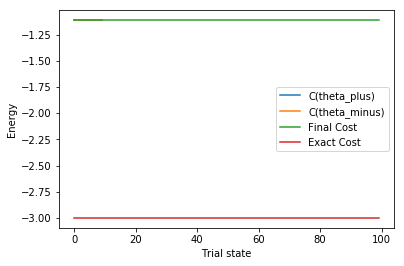

In [15]:
plt.plot(output[2],label='C(theta_plus)')
plt.plot(output[3],label='C(theta_minus)')
plt.plot(np.ones(max_trials)*output[0],label='Final Cost')
plt.plot(np.ones(max_trials)*exact,label='Exact Cost')
plt.legend()
plt.xlabel('Trial state')
plt.ylabel('Energy')

In [ ]:

#Exact Energy
pauli_list=Hamiltonian_from_file(ham_name)
H=make_Hamiltonian(pauli_list)
exact=np.amin(la.eig(H)[0]).real
        
# Optimization
eval_hamiltonian_partial=partial(eval_hamiltonian,n,m,ham_name,device,shots,H)
eval_hamiltonian_partial(theta)

output=SPSA_optimization(eval_hamiltonian_partial,theta,SPSA_params,max_trials,1);
plt.plot(output[2],label='E(theta_plus)')
plt.plot(output[3],label='E(theta_minus)')
plt.plot(np.ones(max_trials)*output[0],label='Final Energy')
plt.plot(np.ones(max_trials)*exact,label='Exact Energy')
plt.legend()
plt.xlabel('Trial state')
plt.ylabel('Energy')

In [ ]:
# Quantum circuit parameters
device = 'local_qasm_simulator' # the device to run on
shots = 1    # the number of shots in the experiment. 
entangler_map = {0: [1], 1: [2], 2: [3]} # the map of two-qubit gates with control at key and target at values


# Quantum circuit parameters
entangler_map = {0: [1], 1: [2], 2: [3]} # the map of two-qubit gates with control at key and target at values

# Numerical parameters 
SPSA_parameters = np.array([.3,0.602,0,.1,0.101]) #[a, alpha, A, c, gamma]
max_trials = 100;
max_depth = 3



# Numerical parameters 
SPSA_parameters = np.array([.3,0.602,0,.1,0.101]) #[a, alpha, A, c, gamma]
max_trials = 100;
max_depth = 3

cost, data_save, cost_save = SPSA_Minimization(Q_program, alpha, beta, n, device, shots, entangler_map, SPSA_parameters, max_trials, max_depth)

print('m = 1 ' + str(cost[0]) + ' m = 2 ' + str(cost[1]) + 'm = 3 ' + str(cost[2]))

In [ ]:
def evaluate_objective(Q_program,n,m,device,shots,theta,w1,w2):
    cost=0
    # STACK QUANTUM CIRCUITS ASSOCIATED TO EACH PAULI TERM AND EXECUTE THEM 
    if shots!=1:
        
        circuits=[]
        trial_circuit=[]
        
        for i in range(len(ham_array)//2):     

            trial_circuit.append(trial_circuit_ryrz(n,m,theta,entangler_map,ham_array[i*2],True))
            circuits.append("trial_circuit_label"+str(i))
            Q_program.add_circuit(circuits[i],trial_circuit[i])


        # EXECUTE THE CIRCUITS STACKED 

        Q_program.execute(circuits,device,shots)
    
    
    
        pauli_list=Hamiltonian_from_file(file_name)

        for i in range(len(ham_array)//2):#loop over Pauli terms

            pauli_avg=Energy_Estimate(Q_program.get_counts("trial_circuit_label"+str(i)),pauli_list[i])
            avg_energy+=pauli_avg
    
    else:
    
        circuit=['circuit']
        Q_program.add_circuit(circuit[0],trial_circuit_ry(n,m,theta,entangler_map,None,False))
        Q_program.execute(circuit,device,shots)
        avg_energy=(np.inner(np.conjugate(Q_program.get_data(circuit[0])['quantum_state']),np.dot(H,Q_program.get_data(circuit[0])['quantum_state']))).real
        
    
    return avg_energy,std_energy

In [ ]:
n=2
m=
device='local_qasm_simulator'
SPSA_params=[1,.1,.602,.101,0]
theta=np.zeros(2*n*m)
entangler_map={0: [1]} # the map of two-qubit gates with control at key and target at values
shots=1000
max_trials=25

#Exact Energy
pauli_list=Hamiltonian_from_file('H2/H2Equilibrium.txt')
eigen=la.eig(make_Hamiltonian(pauli_list))
exact=np.amin(eigen[0])
        
# Optimization
eval_hamiltonian_partial=partial(eval_hamiltonian,n,m,'H2/H2Equilibrium.txt',device,shots)
output=SPSA_optimization(eval_hamiltonian_partial,theta,SPSA_params,max_trials,1);
plt.plot(output[2],label='E(theta_plus)')
plt.plot(output[3],label='E(theta_minus)')
plt.plot(np.ones(max_trials)*output[0],label='Final Energy')
plt.plot(np.ones(max_trials)*exact,label='Exact Energy')
plt.legend()

In [ ]:
# cost function H = alpha_i z_i + beta_ij z_i z_j
n =4
alpha = np.zeros(n)
beta = np.zeros((n, n))
beta[0, 1] = 1
beta[0, 2] = 1
beta[1, 2] = 1
beta[1, 3] = 1
beta[2, 3] = 1

In [ ]:
#Setting up a quantum program and connecting to the Quantum Experience API
Q_program = QuantumProgram()
# set the APIToken and API url
Q_program.set_api(Qconfig.APItoken, Qconfig.config["url"])

In [ ]:
#Making the Hamiltonian in its full form and getting the lowest eigenvalue and egienvector
H = make_Hamiltonian(n,alpha,beta)
w, v = la.eigh(H, eigvals=(0, 1))
print(w)
v

In [ ]:
# Quantum circuit parameters
device = 'local_qasm_simulator' # the device to run on
shots = 8192    # the number of shots in the experiment. 
entangler_map = {0: [1], 1: [2], 2: [3]} # the map of two-qubit gates with control at key and target at values

# Numerical parameters 
SPSA_parameters = np.array([.3,0.602,0,.1,0.101]) #[a, alpha, A, c, gamma]
max_trials = 100;
max_depth = 3

cost, data_save, cost_save = SPSA_Minimization(Q_program, alpha, beta, n, device, shots, entangler_map, SPSA_parameters, max_trials, max_depth)

print('m = 1 ' + str(cost[0]) + ' m = 2 ' + str(cost[1]) + 'm = 3 ' + str(cost[2]))

In [ ]:
# plotting data
plt.plot(range(max_trials), cost_save[0])
plot_histogram(data_save[0])

plt.plot(range(max_trials), cost_save[1])
plot_histogram(data_save[1])

plt.plot(range(max_trials), cost_save[2])
plot_histogram(data_save[2])

## Four Qubits  (fast) <a id='sectionmaxcutfourfast'></a>

    Graph:   
             X---X 
             | \ |
             X---X
           
The ground state is degenerate and is either $|100\rangle$, $|010\rangle$ and $|001\rangle$.

In [ ]:
# cost function H = alpha_i z_i + beta_ij z_i z_j
n =4
alpha = np.zeros(n)
beta = np.zeros((n, n))
beta[0, 1] = 1
beta[0, 2] = 1
beta[1, 2] = 1
beta[1, 3] = 1
beta[2, 3] = 1

In [ ]:
#Setting up a quantum program and connecting to the Quantum Experience API
Q_program = QuantumProgram()
# set the APIToken and API url
Q_program.set_api(Qconfig.APItoken, Qconfig.config["url"])

In [ ]:
# Quantum circuit parameters
entangler_map = {0: [1], 1: [2], 2: [3]} # the map of two-qubit gates with control at key and target at values

# Numerical parameters 
SPSA_parameters = np.array([.3,0.602,0,.1,0.101]) #[a, alpha, A, c, gamma]
max_trials = 100;
max_depth = 3

cost, data_save, cost_save = SPSA_Minimization_fast(Q_program, alpha, beta, n, entangler_map, SPSA_parameters, max_trials, max_depth)

print('m = 1 ' + str(cost[0]) + ' m = 2 ' + str(cost[1]) + 'm = 3 ' + str(cost[2]))

In [ ]:
# plotting data
plt.plot(range(max_trials), cost_save[0])
plot_histogram(data_save[0])

plt.plot(range(max_trials), cost_save[1])
plot_histogram(data_save[1])

plt.plot(range(max_trials), cost_save[2])
plot_histogram(data_save[2])

## 10 qubits<a id='sectionmaxcutten'></a>

In [ ]:
n = 10

# cost function H = alpha_i z_i + beta_ij z_i z_j
alpha = np.zeros(n)
beta = np.random.choice([0, 0.5], size=(n,n), p=[1./3, 2./3])

In [ ]:
# quantum circuit parameters
device = 'simulator' # the device to run on
shots = 8192    # the number of shots in the experiment 
entangler_map = {0: [1], 1: [2], 2: [3], 3: [4], 4: [5], 5: [6], 6: [7], 7: [8], 8: [9]} # the map of two-qubit gates with control at key and target at values

# Numerical parameters 
SPSA_parameters = np.array([.3,0.602,0,.1,0.101]) # [a, alpha, A, c, gamma]
max_trials = 100;
theta_depth_1 = np.random.randn(1*n) # initial controls 
theta_depth_2 = np.random.randn(2*n) # initial controls 
theta_depth_3 = np.random.randn(3*n) # initial controls 



trial_circuit_depth_1 =  trial_funtion_optimization(n,1,theta_depth_1,entangler_map) 
trial_circuit_depth_2 =  trial_funtion_optimization(n,2,theta_depth_2,entangler_map) 
trial_circuit_depth_3 =  trial_funtion_optimization(n,3,theta_depth_3,entangler_map) 

program = [trial_circuit_depth_1,trial_circuit_depth_2,trial_circuit_depth_3]
out = run_program(program,api,device,shots,max_credits=3)
results=combine_jobs([out['id']], api, wait=20, timeout=440)  
cost_depth_1 = cost_classical(get_data(results,0),n,alpha,beta)
cost_depth_2 = cost_classical(get_data(results,1),n,alpha,beta)
cost_depth_3 = cost_classical(get_data(results,2),n,alpha,beta)
print('m=1 ' + str(cost_depth_1) + ' m=2 ' + str(cost_depth_2) + 'm=3 ' + str(cost_depth_3))

In [ ]:
# plotting data
plt.plot(range(max_trials), cost_plus_depth_1, range(max_trials), cost_minus_depth_1)
plot_histogram(get_data(results,0),n)
plt.plot(range(max_trials), cost_plus_depth_2, range(max_trials), cost_minus_depth_2)
plot_histogram(get_data(results,1),n)
plt.plot(range(max_trials), cost_plus_depth_3, range(max_trials), cost_minus_depth_3)
plot_histogram(get_data(results,2),n)

In [ ]:
# cost function H = alpha_i z_i + beta_ij z_i z_j
n = 10
alpha = np.zeros(n)
beta = np.random.choice([0, 0.5], size=(n,n), p=[1./3, 2./3])
for i in range(n):
    for j in range(i):
        beta[j,i]=beta[i,j]
for i in range(n):
    beta[i,i]=0;

In [ ]:
# quantum circuit parameters
device = 'simulator' # the device to run on
shots = 8192    # the number of shots in the experiment 
entangler_map = {0: [1], 1: [2], 2: [3], 3: [4], 4: [5], 5: [6], 6: [7], 7: [8], 8: [9]} # the map of two-qubit gates with control at key and target at values

# Numerical parameters 
SPSA_parameters = np.array([.3,0.602,0,.1,0.101]) #[a, alpha, A, c, gamma]
max_trials = 100;
theta_depth_1 = np.random.randn(1*n) # initial controls 
theta_depth_2 = np.random.randn(2*n) # initial controls 
theta_depth_3 = np.random.randn(3*n) # initial controls 

cost_plus_depth_1=np.zeros(max_trials)
cost_minus_depth_1=np.zeros(max_trials)
cost_plus_depth_2=np.zeros(max_trials)
cost_minus_depth_2=np.zeros(max_trials)
cost_plus_depth_3=np.zeros(max_trials)
cost_minus_depth_3=np.zeros(max_trials)

for k in range(max_trials):
    print('trial ' + str(k) + " of " + str(max_trials))
    a_spsa = float(SPSA_parameters[0])/np.power(k+1+SPSA_parameters[2], SPSA_parameters[1])
    c_spsa = float(SPSA_parameters[3])/np.power(k+1, SPSA_parameters[4])

    Delta_depth_1 = 2*np.random.randint(2,size=n*1)-1 # \pm 1 random distribution 
    Delta_depth_2 = 2*np.random.randint(2,size=n*2)-1 # \pm 1 random distribution 
    Delta_depth_3 = 2*np.random.randint(2,size=n*3)-1 # \pm 1 random distribution 
    
    theta_plus_depth_1 = theta_depth_1 + c_spsa*Delta_depth_1
    theta_minus_depth_1 = theta_depth_1 - c_spsa*Delta_depth_1
    theta_plus_depth_2 = theta_depth_2 + c_spsa*Delta_depth_2
    theta_minus_depth_2 = theta_depth_2 - c_spsa*Delta_depth_2
    theta_plus_depth_3 = theta_depth_3 + c_spsa*Delta_depth_3
    theta_minus_depth_3 = theta_depth_3 - c_spsa*Delta_depth_3

    trial_circuit_plus_depth_1 = trial_funtion_optimization(n,1,theta_plus_depth_3,entangler_map) 
    trial_circuit_minus_depth_1 = trial_funtion_optimization(n,1,theta_minus_depth_1,entangler_map) 
    trial_circuit_plus_depth_2 = trial_funtion_optimization(n,2,theta_plus_depth_3,entangler_map) 
    trial_circuit_minus_depth_2 = trial_funtion_optimization(n,2,theta_minus_depth_2,entangler_map)
    trial_circuit_plus_depth_3 = trial_funtion_optimization(n,3,theta_plus_depth_3,entangler_map) 
    trial_circuit_minus_depth_3 = trial_funtion_optimization(n,3,theta_minus_depth_3,entangler_map)
    
    program = [trial_circuit_plus_depth_1,trial_circuit_minus_depth_1,trial_circuit_plus_depth_2
               ,trial_circuit_minus_depth_2,trial_circuit_plus_depth_3,trial_circuit_minus_depth_3]
    out = run_program(program,api,device,shots,max_credits=3)
    results=combine_jobs([out['id']], api, wait=20, timeout=440)
    
    cost_plus_depth_1[k] = cost_classical(get_data(results,0),n,alpha,beta)
    cost_minus_depth_1[k] = cost_classical(get_data(results,1),n,alpha,beta)
    cost_plus_depth_2[k] = cost_classical(get_data(results,2),n,alpha,beta)
    cost_minus_depth_2[k] = cost_classical(get_data(results,3),n,alpha,beta)
    cost_plus_depth_3[k] = cost_classical(get_data(results,4),n,alpha,beta)
    cost_minus_depth_3[k] = cost_classical(get_data(results,5),n,alpha,beta)
    
    g_spsa_depth_1 = (cost_plus_depth_1[k]-cost_minus_depth_1[k])*Delta_depth_1/(2.0*c_spsa)
    g_spsa_depth_2 = (cost_plus_depth_2[k]-cost_minus_depth_2[k])*Delta_depth_2/(2.0*c_spsa)
    g_spsa_depth_3 = (cost_plus_depth_3[k]-cost_minus_depth_3[k])*Delta_depth_3/(2.0*c_spsa)

    theta_depth_1 = theta_depth_1 - a_spsa*g_spsa_depth_1
    theta_depth_2 = theta_depth_2 - a_spsa*g_spsa_depth_2
    theta_depth_3 = theta_depth_3 - a_spsa*g_spsa_depth_3
    print(cost_minus_depth_3[k] +   cost_plus_depth_3[k])

trial_circuit_depth_1 =  trial_funtion_optimization(n,1,theta_depth_1,entangler_map) 
trial_circuit_depth_2 =  trial_funtion_optimization(n,2,theta_depth_2,entangler_map) 
trial_circuit_depth_3 =  trial_funtion_optimization(n,3,theta_depth_3,entangler_map) 

program = [trial_circuit_depth_1,trial_circuit_depth_2,trial_circuit_depth_3]
out = run_program(program,api,device,shots,max_credits=3)
results=combine_jobs([out['id']], api, wait=20, timeout=440)  
cost_depth_1 = cost_classical(get_data(results,0),n,alpha,beta)
cost_depth_2 = cost_classical(get_data(results,1),n,alpha,beta)
cost_depth_3 = cost_classical(get_data(results,2),n,alpha,beta)
print('m=1 ' + str(cost_depth_1) + ' m=2 ' + str(cost_depth_2) + 'm=3 ' + str(cost_depth_3))

In [ ]:
# plotting data
plt.plot(range(max_trials), cost_plus_depth_1, range(max_trials), cost_minus_depth_1)
plot_histogram(get_data(results,0),n)
plt.plot(range(max_trials), cost_plus_depth_2, range(max_trials), cost_minus_depth_2)
plot_histogram(get_data(results,1),n)
plt.plot(range(max_trials), cost_plus_depth_3, range(max_trials), cost_minus_depth_3)
plot_histogram(get_data(results,2),n)

## Max Cut (DONNA) 

In [ ]:
# cost function H = alpha_i z_i + beta_ij z_i z_j
n = 6
alpha = np.zeros(n)
beta = np.zeros((n, n))
beta[0, 1] = 93/2
beta[0, 4] = 17/2
beta[0, 5] = 51/2
beta[1, 0] = 93/2
beta[1, 5] = 13/2
beta[1, 2] = 77/2
beta[2, 1] = 77/2
beta[2, 3] = 31/2
beta[2, 5] = 23/2
beta[3,2] = 31/2
beta[3,4] = 7/2
beta[3,5] = 46/2
beta[4,3] = 7/2
beta[4,5] = 65/2
beta[4,0] = 17/2

beta[5,0] = 51/2
beta[5,1] = 13/2
beta[5,2] = 23/2
beta[5,3] = 46/2
beta[5,4] = 65/2

In [ ]:
# quantum circuit parameters
device = 'simulator' # the device to run on
shots = 8192    # the number of shots in the experiment 
entangler_map = {0: [1], 1: [2], 2: [3], 3: [4]} # the map of two-qubit gates with control at key and target at values

# Numerical parameters 
SPSA_parameters = np.array([3,0.602,0,.3,0.101]) #[a, alpha, A, c, gamma]
max_trials = 100;
theta_depth_1 = np.random.randn(1*n) # initial controls 
theta_depth_2 = np.random.randn(2*n) # initial controls 
theta_depth_3 = np.random.randn(3*n) # initial controls 

cost_plus_depth_1=np.zeros(max_trials)
cost_minus_depth_1=np.zeros(max_trials)
cost_plus_depth_2=np.zeros(max_trials)
cost_minus_depth_2=np.zeros(max_trials)
cost_plus_depth_3=np.zeros(max_trials)
cost_minus_depth_3=np.zeros(max_trials)

for k in range(max_trials):
    print('trial ' + str(k) + " of " + str(max_trials))
    a_spsa = float(SPSA_parameters[0])/np.power(k+1+SPSA_parameters[2], SPSA_parameters[1])
    c_spsa = float(SPSA_parameters[3])/np.power(k+1, SPSA_parameters[4])

    Delta_depth_1 = 2*np.random.randint(2,size=n*1)-1 # \pm 1 random distribution 
    Delta_depth_2 = 2*np.random.randint(2,size=n*2)-1 # \pm 1 random distribution 
    Delta_depth_3 = 2*np.random.randint(2,size=n*3)-1 # \pm 1 random distribution 
    
    theta_plus_depth_1 = theta_depth_1 + c_spsa*Delta_depth_1
    theta_minus_depth_1 = theta_depth_1 - c_spsa*Delta_depth_1
    theta_plus_depth_2 = theta_depth_2 + c_spsa*Delta_depth_2
    theta_minus_depth_2 = theta_depth_2 - c_spsa*Delta_depth_2
    theta_plus_depth_3 = theta_depth_3 + c_spsa*Delta_depth_3
    theta_minus_depth_3 = theta_depth_3 - c_spsa*Delta_depth_3

    trial_circuit_plus_depth_1 = trial_funtion_optimization(n,1,theta_plus_depth_3,entangler_map) 
    trial_circuit_minus_depth_1 = trial_funtion_optimization(n,1,theta_minus_depth_1,entangler_map) 
    trial_circuit_plus_depth_2 = trial_funtion_optimization(n,2,theta_plus_depth_3,entangler_map) 
    trial_circuit_minus_depth_2 = trial_funtion_optimization(n,2,theta_minus_depth_2,entangler_map)
    trial_circuit_plus_depth_3 = trial_funtion_optimization(n,3,theta_plus_depth_3,entangler_map) 
    trial_circuit_minus_depth_3 = trial_funtion_optimization(n,3,theta_minus_depth_3,entangler_map)
    
    program = [trial_circuit_plus_depth_1,trial_circuit_minus_depth_1,trial_circuit_plus_depth_2
               ,trial_circuit_minus_depth_2,trial_circuit_plus_depth_3,trial_circuit_minus_depth_3]
    out = run_program(program,api,device,shots,max_credits=3)
    results=combine_jobs([out['id']], api, wait=20, timeout=440)
    
    cost_plus_depth_1[k] = cost_classical(get_data(results,0),n,alpha,beta)
    cost_minus_depth_1[k] = cost_classical(get_data(results,1),n,alpha,beta)
    cost_plus_depth_2[k] = cost_classical(get_data(results,2),n,alpha,beta)
    cost_minus_depth_2[k] = cost_classical(get_data(results,3),n,alpha,beta)
    cost_plus_depth_3[k] = cost_classical(get_data(results,4),n,alpha,beta)
    cost_minus_depth_3[k] = cost_classical(get_data(results,5),n,alpha,beta)
    
    g_spsa_depth_1 = (cost_plus_depth_1[k]-cost_minus_depth_1[k])*Delta_depth_1/(2.0*c_spsa)
    g_spsa_depth_2 = (cost_plus_depth_2[k]-cost_minus_depth_2[k])*Delta_depth_2/(2.0*c_spsa)
    g_spsa_depth_3 = (cost_plus_depth_3[k]-cost_minus_depth_3[k])*Delta_depth_3/(2.0*c_spsa)

    theta_depth_1 = theta_depth_1 - a_spsa*g_spsa_depth_1
    theta_depth_2 = theta_depth_2 - a_spsa*g_spsa_depth_2
    theta_depth_3 = theta_depth_3 - a_spsa*g_spsa_depth_3

trial_circuit_depth_1 =  trial_funtion_optimization(n,1,theta_depth_1,entangler_map) 
trial_circuit_depth_2 =  trial_funtion_optimization(n,2,theta_depth_2,entangler_map) 
trial_circuit_depth_3 =  trial_funtion_optimization(n,3,theta_depth_3,entangler_map) 

program = [trial_circuit_depth_1,trial_circuit_depth_2,trial_circuit_depth_3]
out = run_program(program,api,device,shots,max_credits=3)
results=combine_jobs([out['id']], api, wait=20, timeout=440)  
cost_depth_1 = cost_classical(get_data(results,0),n,alpha,beta)
cost_depth_2 = cost_classical(get_data(results,1),n,alpha,beta)
cost_depth_3 = cost_classical(get_data(results,2),n,alpha,beta)
print('m=1 ' + str(cost_depth_1) + ' m=2 ' + str(cost_depth_2) + 'm=3 ' + str(cost_depth_3))

In [ ]:
# plotting data
plt.plot(range(max_trials), cost_plus_depth_1, range(max_trials), cost_minus_depth_1)
plot_histogram(get_data(results,0),n)
plt.plot(range(max_trials), cost_plus_depth_2, range(max_trials), cost_minus_depth_2)
plot_histogram(get_data(results,1),n)
plt.plot(range(max_trials), cost_plus_depth_3, range(max_trials), cost_minus_depth_3)
plot_histogram(get_data(results,2),n)

## REAL

In [ ]:
# quantum circuit parameters
device = 'real' # the device to run on
shots = 8192    # the number of shots in the experiment
n = 2
entangler_map = {0: [1]} # the map of two-qubit gates with control at key and target at values

# Numerical parameters 
SPSA_parameters = np.array([.3,0.602,0,.3,0.101]) #[a, alpha, A, c, gamma]
max_trials = 100;
theta_depth_1 = np.random.randn(1*n) # initial controls 
theta_depth_2 = np.random.randn(2*n) # initial controls 
theta_depth_3 = np.random.randn(3*n) # initial controls 

cost_plus_depth_1=np.zeros(max_trials)
cost_minus_depth_1=np.zeros(max_trials)
cost_plus_depth_2=np.zeros(max_trials)
cost_minus_depth_2=np.zeros(max_trials)
cost_plus_depth_3=np.zeros(max_trials)
cost_minus_depth_3=np.zeros(max_trials)

for k in range(max_trials):
    print('trial ' + str(k) + " of " + str(max_trials))
    a_spsa = float(SPSA_parameters[0])/np.power(k+1+SPSA_parameters[2], SPSA_parameters[1])
    c_spsa = float(SPSA_parameters[3])/np.power(k+1, SPSA_parameters[4])

    Delta_depth_1 = 2*np.random.randint(2,size=n*1)-1 # \pm 1 random distribution 
    Delta_depth_2 = 2*np.random.randint(2,size=n*2)-1 # \pm 1 random distribution 
    Delta_depth_3 = 2*np.random.randint(2,size=n*3)-1 # \pm 1 random distribution 
    
    theta_plus_depth_1 = theta_depth_1 + c_spsa*Delta_depth_1
    theta_minus_depth_1 = theta_depth_1 - c_spsa*Delta_depth_1
    theta_plus_depth_2 = theta_depth_2 + c_spsa*Delta_depth_2
    theta_minus_depth_2 = theta_depth_2 - c_spsa*Delta_depth_2
    theta_plus_depth_3 = theta_depth_3 + c_spsa*Delta_depth_3
    theta_minus_depth_3 = theta_depth_3 - c_spsa*Delta_depth_3

    trial_circuit_plus_depth_1 = trial_funtion_optimization(n,1,theta_plus_depth_3,entangler_map) 
    trial_circuit_minus_depth_1 = trial_funtion_optimization(n,1,theta_minus_depth_1,entangler_map) 
    trial_circuit_plus_depth_2 = trial_funtion_optimization(n,2,theta_plus_depth_3,entangler_map) 
    trial_circuit_minus_depth_2 = trial_funtion_optimization(n,2,theta_minus_depth_2,entangler_map)
    trial_circuit_plus_depth_3 = trial_funtion_optimization(n,3,theta_plus_depth_3,entangler_map) 
    trial_circuit_minus_depth_3 = trial_funtion_optimization(n,3,theta_minus_depth_3,entangler_map)
    
    program = [trial_circuit_plus_depth_1,trial_circuit_minus_depth_1,trial_circuit_plus_depth_2
               ,trial_circuit_minus_depth_2,trial_circuit_plus_depth_3,trial_circuit_minus_depth_3]
    out = run_program(program,api,device,shots,max_credits=5)
    results=combine_jobs([out['id']], api, wait=20, timeout=480)
    
    cost_plus_depth_1[k] = cost_classical(get_data(results,0),n,alpha,beta)
    cost_minus_depth_1[k] = cost_classical(get_data(results,1),n,alpha,beta)
    cost_plus_depth_2[k] = cost_classical(get_data(results,2),n,alpha,beta)
    cost_minus_depth_2[k] = cost_classical(get_data(results,3),n,alpha,beta)
    cost_plus_depth_3[k] = cost_classical(get_data(results,4),n,alpha,beta)
    cost_minus_depth_3[k] = cost_classical(get_data(results,5),n,alpha,beta)
    
    g_spsa_depth_1 = (cost_plus_depth_1[k]-cost_minus_depth_1[k])*Delta_depth_1/(2.0*c_spsa)
    g_spsa_depth_2 = (cost_plus_depth_2[k]-cost_minus_depth_2[k])*Delta_depth_2/(2.0*c_spsa)
    g_spsa_depth_3 = (cost_plus_depth_3[k]-cost_minus_depth_3[k])*Delta_depth_3/(2.0*c_spsa)

    theta_depth_1 = theta_depth_1 - a_spsa*g_spsa_depth_1
    theta_depth_2 = theta_depth_2 - a_spsa*g_spsa_depth_2
    theta_depth_3 = theta_depth_3 - a_spsa*g_spsa_depth_3

trial_circuit_depth_1 =  trial_funtion_optimization(n,1,theta_depth_1,entangler_map) 
trial_circuit_depth_2 =  trial_funtion_optimization(n,2,theta_depth_2,entangler_map) 
trial_circuit_depth_3 =  trial_funtion_optimization(n,3,theta_depth_3,entangler_map) 

program = [trial_circuit_depth_1,trial_circuit_depth_2,trial_circuit_depth_3]
out = run_program(program,api,device,shots,max_credits=5)
results=combine_jobs([out['id']], api, wait=20, timeout=240)  
cost_depth_1 = cost_classical(get_data(results,0),n,alpha,beta)
cost_depth_2 = cost_classical(get_data(results,1),n,alpha,beta)
cost_depth_3 = cost_classical(get_data(results,2),n,alpha,beta)
print('m=1 ' + str(cost_depth_1) + ' m=2 ' + str(cost_depth_2) + 'm=3 ' + str(cost_depth_3))

In [ ]:
# plotting data
plt.plot(range(max_trials), cost_plus_depth_1, range(max_trials), cost_minus_depth_1)
plot_histogram(get_data(results,0),n)
plt.plot(range(max_trials), cost_plus_depth_2, range(max_trials), cost_minus_depth_2)
plot_histogram(get_data(results,1),n)
plt.plot(range(max_trials), cost_plus_depth_3, range(max_trials), cost_minus_depth_3)
plot_histogram(get_data(results,2),n)

In [ ]:
The brute force approach is 

What we have just done is the Brute-Force Algorithm:
  Make a list of all possible Hamilton circuits
  Calculate the weight of each Hamilton circuit by adding up the weights of its edges.
  Choose the Hamilton circuit with the smallest total weight.
 
 
  The Brute-Force Algorithm is optimal: it is guaranteed to find a solution.
  OTOH, the algorithm is inefficient: it has to look at all (N − 1)! Hamilton circuits, and this can take a long time.